Medical Image Classification
=====================
This notebook is an end-to-end script for training and validating a specific model on the task to classify medical image into 6 different classes 

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:

import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import RandomSampler, WeightedRandomSampler
from sklearn.model_selection import train_test_split

from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
from datasets import load_metric
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')


What about data?
----------------

The Medical MNIST dataset which contains 58954 medical images of 6 classes.

You can download the dataset here: https://www.kaggle.com/datasets/andrewmvd/medical-mnist

The 6 image classes of human body included in this dataset are:

1. AbdomenCT
2. BreastMRI
3. ChestXR
4. ChestCT
5. Hand
6. HeadCT


#### Let's analyze the dataset

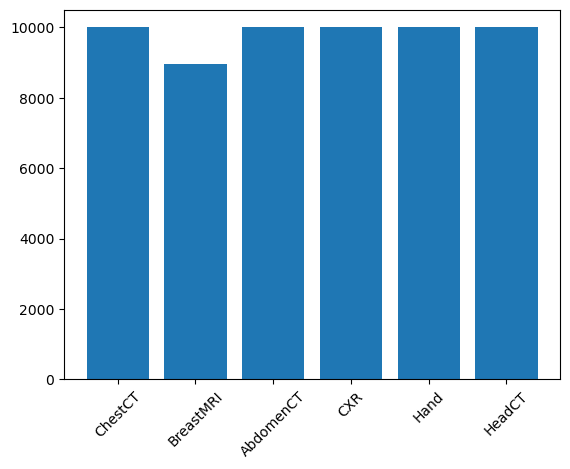

In [3]:
data_dir = os.path.join(os.getcwd(),"dataset")

count_dict = {}
for foldername in os.listdir(data_dir):
    count_dict[foldername] = 0
    folderpath = os.path.join(data_dir, foldername)
    for file in os.listdir(folderpath):
        count_dict[foldername] += 1

# visualize dataset
class_names = list(count_dict.keys())
class_counts = list(count_dict.values())

plt.bar(range(len(count_dict)), class_counts, tick_label=class_names)
plt.xticks(rotation = 45)
plt.show()

The image has good balance in terms of number of images per class.

#### Pre-processing the dataset
The dataset was already in ready-for-using structure.

#### Let's visualize some examples

/tmp/ipykernel_13086/3446485424.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im_sample = imageio.imread(tpl[t][2][i])


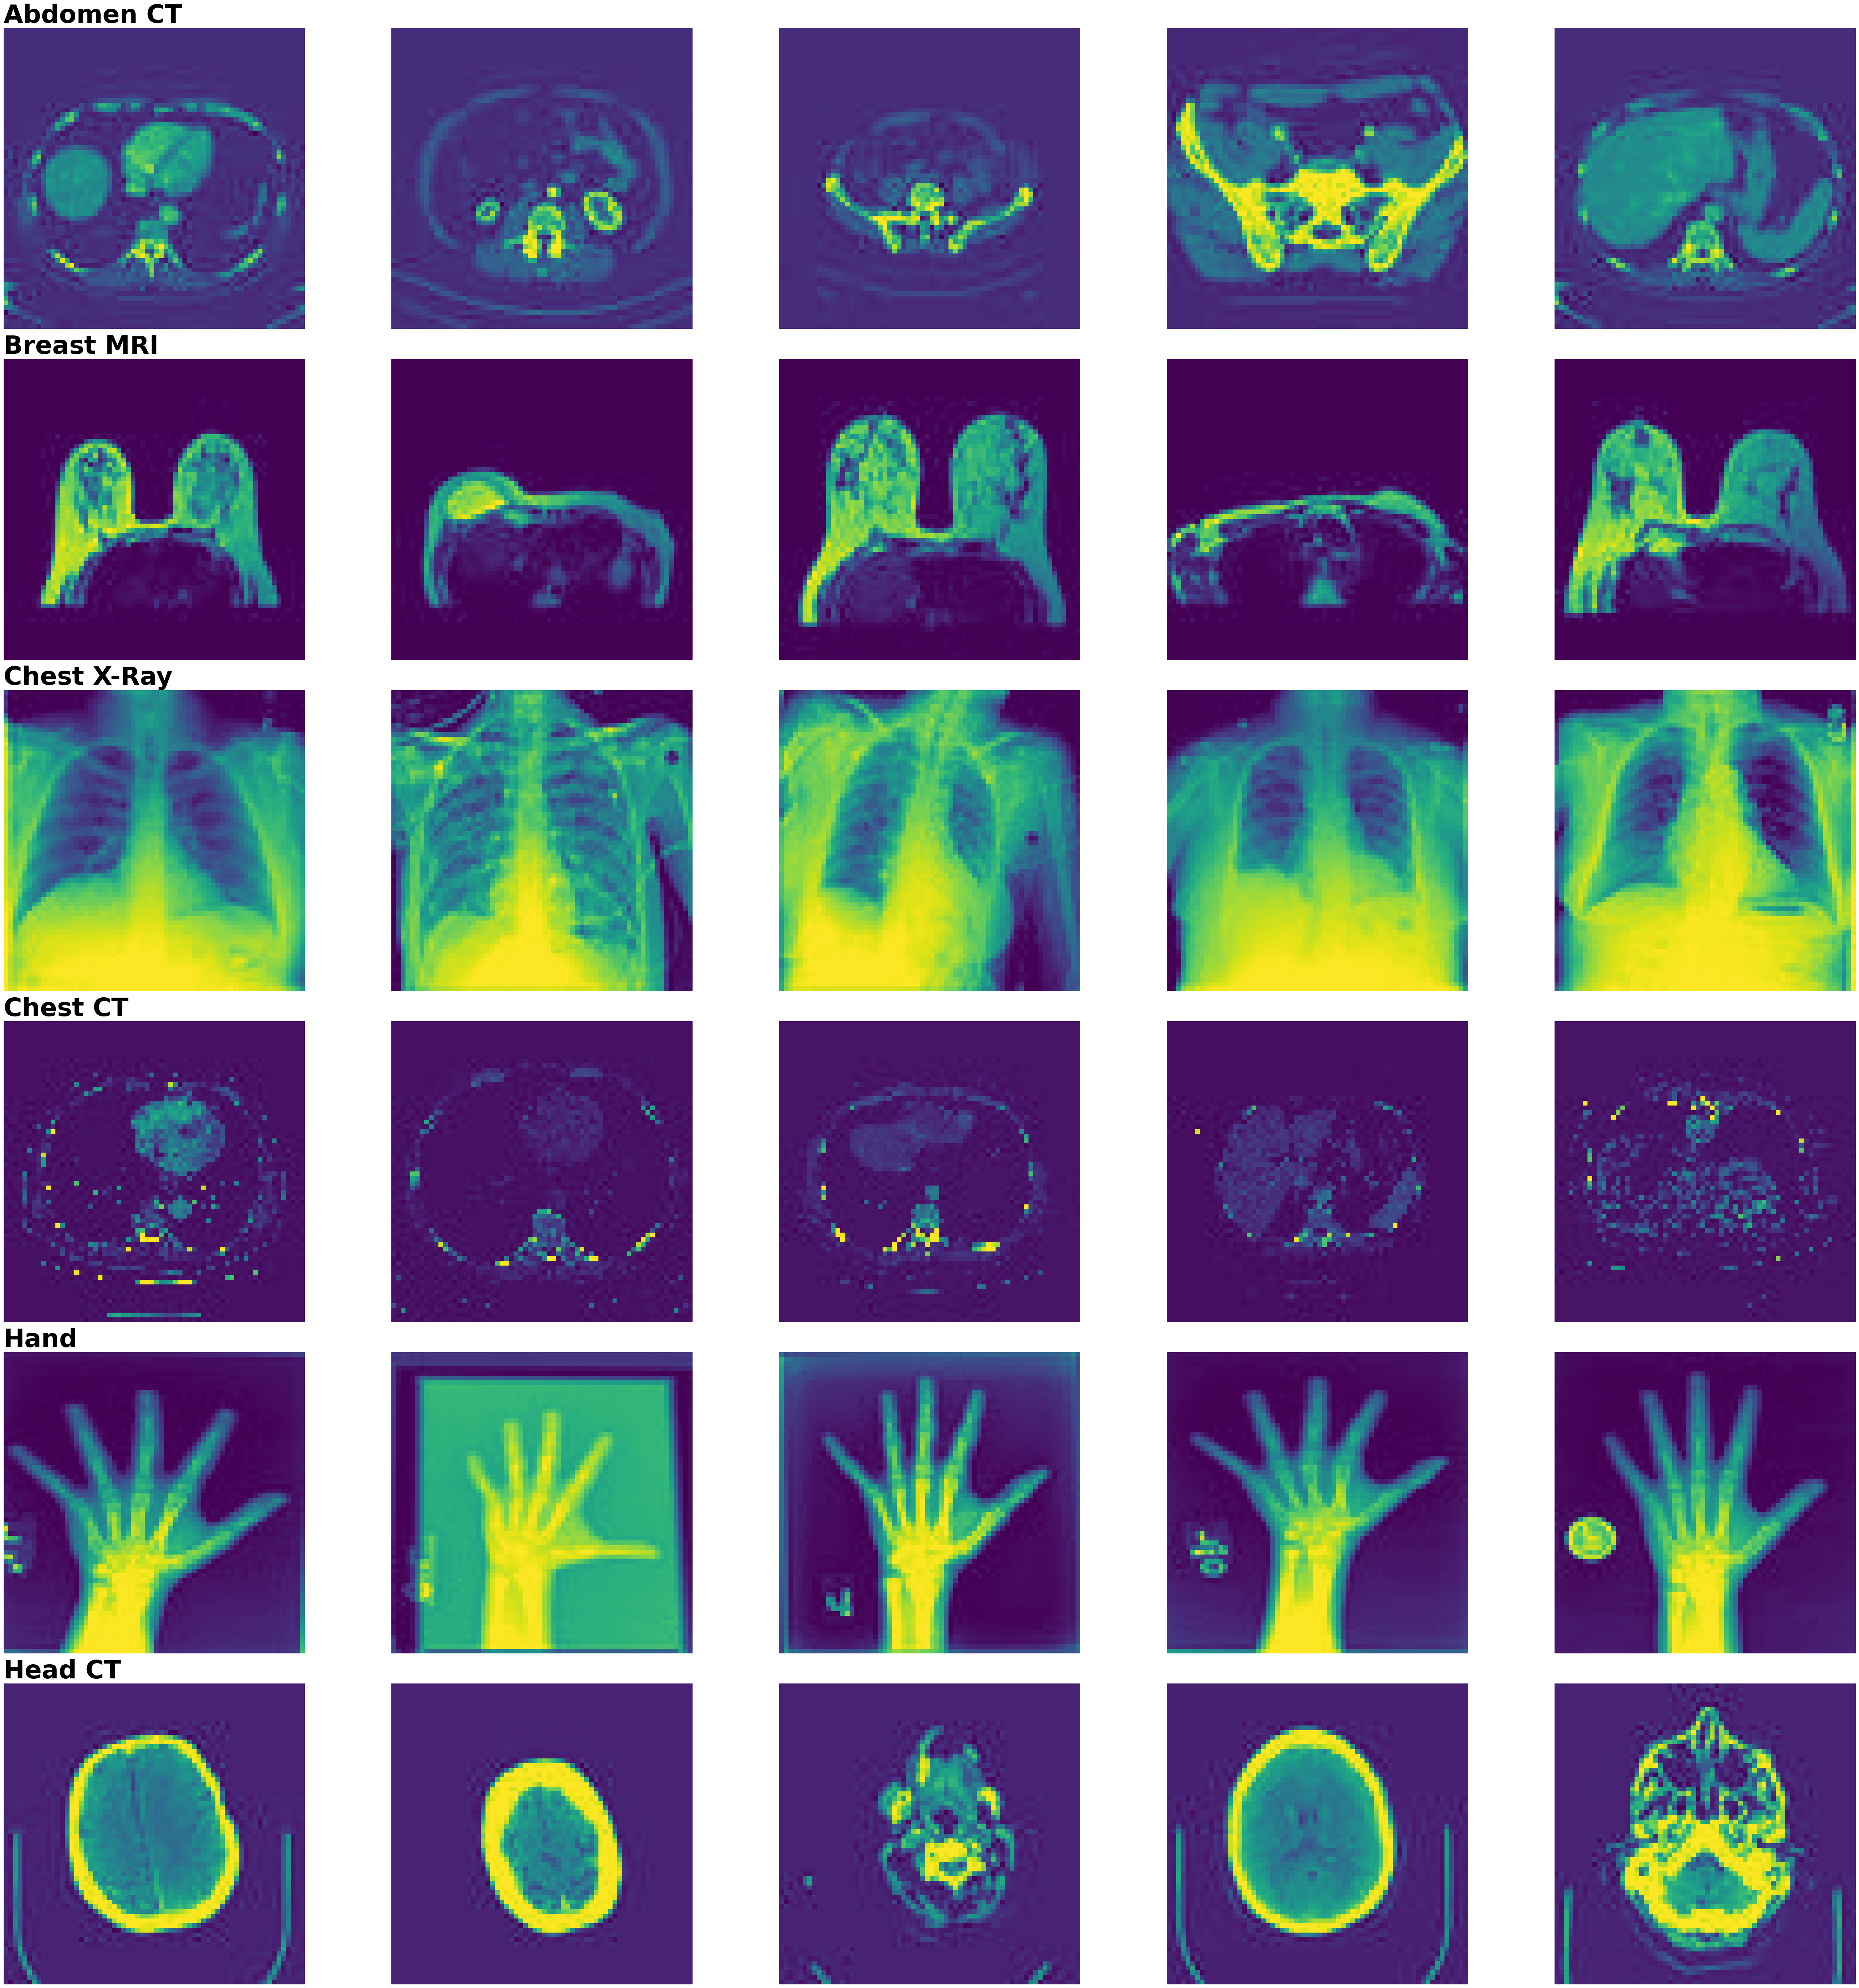

In [4]:
#Visualizing the images

tpl = [('AbdomenCT', 'Abdomen CT', []),
         ('BreastMRI', 'Breast MRI', []),
         ('CXR', 'Chest X-Ray', []),
         ('ChestCT', 'Chest CT', []),
         ('Hand', 'Hand', []),
         ('HeadCT', 'Head CT', [])]

fig = plt.figure(figsize=(55, 55))

for t in tpl:
    folderpath = os.path.join(data_dir, t[0])
    c = 0
    for file in os.listdir(folderpath):
        t[2].append(os.path.join(folderpath, file))
        c += 1
        if c == 5:
            break
    
for t in range(len(tpl)):
    for i in range(len(tpl[t][2])):
        im_sample = imageio.imread(tpl[t][2][i])
        plt.subplot(6,5,(5*t)+i+1)
        plt.imshow(im_sample)
        plt.axis('off')
        if i == 0:
            plt.title(tpl[t][1], loc='left', size=50, weight="bold")

plt.tight_layout()
plt.show()

#### Median Frequency Balancing
As we saw above that there is good class balance in our dataset. However, we still want to demonstrate how to solve class imbalance using class weights.

In [5]:
labels = ['AbdomenCT','BreastMRI','CXR','ChestCT','Hand','HeadCT']
classes = ['Abdomen CT','Breast MRI','Chest X-Ray','Chest CT','Hand','Head CT']
class_weights = []

median_freq = np.median(list(count_dict.values()))

for i in range(len(labels)):
    class_weights.append(median_freq/count_dict[labels[i]])
    print(labels[i],":", class_weights[i])

AbdomenCT : 1.0
BreastMRI : 1.1168192986374805
CXR : 1.0
ChestCT : 1.0
Hand : 1.0
HeadCT : 1.0


#### Data Augmentation
It is a common fact that medical data is scarce. But to learn a very good model, the network needs a lot of data. So to tackle the problem we perform data augmentation.

First we normalize the images. Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. The distribution of such data would resemble a Gaussian curve centered at zero.

We also perform data augmentation:
- Flipping the image horizontally: *RandomHorizontalFlip()*
- Rotating image 60 degrees: *RandomRotation()* . 60 degrees is chosen as best practice. 

The augmentation is applied using the *transform.Compose()* function of Pytorch.
Take note, we only augment the training set. This is because, augmentation is done to aid the training process. So there is no point in augmenting the test set.

In [6]:
# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 100
validation_batch_size = 20
test_batch_size = 20

# We compute the weights of individual classes and convert them to tensors
class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_mean),
                    ])


## Train, Test and Validation Split

We split the entire dataset into 3 parts:
- Train: 70%
- Test: 20%
- Validation: 10%

The splitting is done class wise so that we have equal representation of all classes in each subset of the data.

In [7]:
import torch as th
import math

test_size = 0.2
val_size = 0.1
class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector, test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    

dataset = torchvision.datasets.ImageFolder(root=data_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))


Train Data Size: 37730
Test Data Size: 11791
Validation Data Size: 9433


Now we use Pytorch data loader to load the dataset into the memory.

In [8]:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)


Let us see some of the training images.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 4, 1, 2, 4, 2, 2, 0, 0, 4, 5, 3, 3, 2, 1, 1, 1, 2, 5, 3, 3, 5, 1, 4,
        1, 5, 4, 1, 2, 4, 5, 0, 2, 4, 0, 2, 3, 1, 5, 0, 1, 5, 0, 1, 4, 3, 1, 3,
        0, 0, 5, 0, 2, 1, 5, 2, 5, 5, 2, 5, 3, 5, 5, 0, 5, 5, 5, 2, 3, 1, 3, 5,
        5, 5, 2, 4, 4, 4, 0, 3, 4, 5, 3, 1, 4, 1, 1, 4, 5, 5, 1, 0, 3, 0, 5, 4,
        4, 0, 3, 5])
Chest CT,   Hand,  Breast MRI,  Chest X-Ray,   Hand,  Chest X-Ray,  Chest X-Ray,  Abdomen CT,  Abdomen CT,   Hand,  Head CT,  Chest CT,  Chest CT,  Chest X-Ray,  Breast MRI,  Breast MRI,  Breast MRI,  Chest X-Ray,  Head CT,  Chest CT,  Chest CT,  Head CT,  Breast MRI,   Hand,  Breast MRI,  Head CT,   Hand,  Breast MRI,  Chest X-Ray,   Hand,  Head CT,  Abdomen CT,  Chest X-Ray,   Hand,  Abdomen CT,  Chest X-Ray,  Chest CT,  Breast MRI,  Head CT,  Abdomen CT,  Breast MRI,  Head CT,  Abdomen CT,  Breast MRI,   Hand,  Chest CT,  Breast MRI,  Chest CT,  Abdomen CT,  Abdomen CT,  Head CT,  Abdomen CT,  Chest X-Ray,  Breast MRI,  Head CT,  Chest X-Ray,  Head

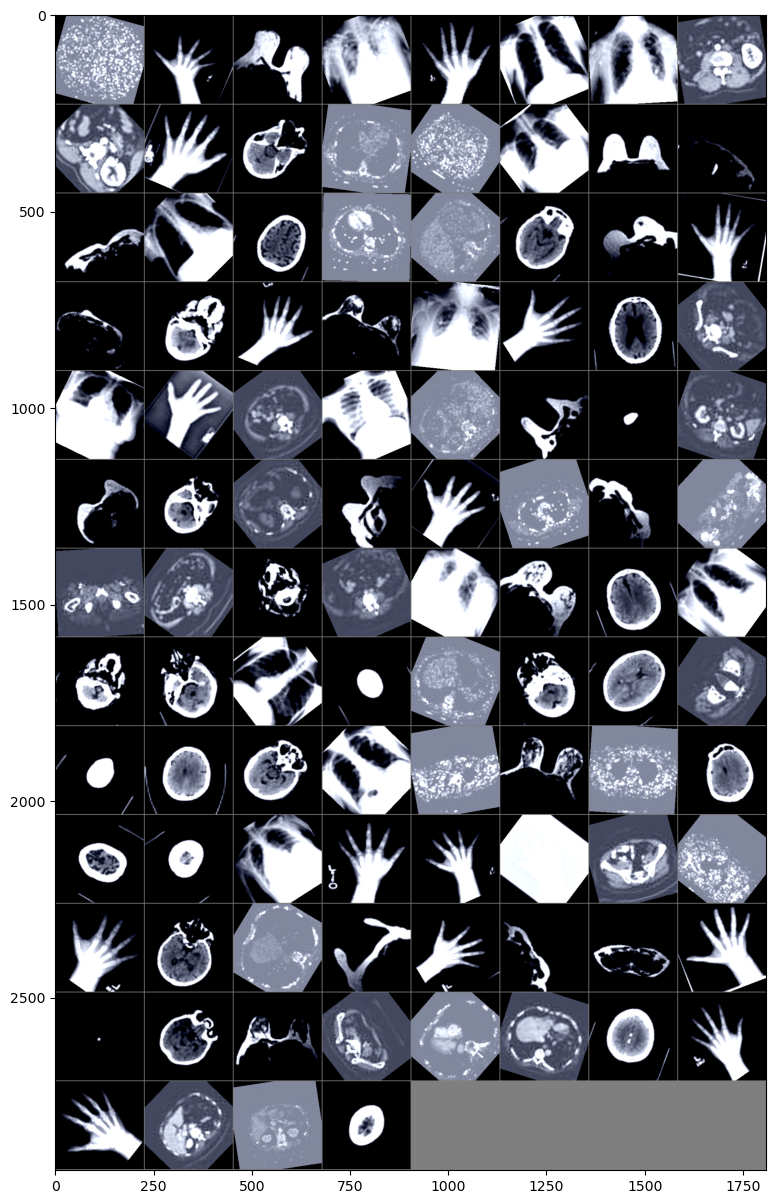

In [9]:
# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = next(dataiter)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

# Resnet50

We build the model

In [10]:
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

num_classes = len(classes)
weights = ResNet50_Weights.DEFAULT
original_net = resnet50(weights=weights)

# We replace last layer of resnet to match our number of classes which is 6
original_net.fc = nn.Linear(2048, num_classes)
net = nn.DataParallel(original_net)
net.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

3. Define a Loss function and Optimizer

Let's use a Classification Cross-Entropy loss.

$H_{y'} (y) := - \sum_{i} y_{i}' \log (y_i)$



The most common and effective Optimizer currently used is **Adam: Adaptive Moments**. You can look [here](https://arxiv.org/abs/1412.6980) for more information.


In [11]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=1e-5)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

These are some helper functions to evaluate the training process.

In [12]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate_model(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

## Train the network


This is when things start to get interesting.
We simply loop over the training data iterator, and feed the inputs to the
network and optimize.



In [13]:
# number of loops over the dataset
num_epochs = 30
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate_model(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 0.452  Accuracy:0.926
Validation Loss: 0.014  Val Accuracy: 0.998
Epoch: 2
Loss: 0.001  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 3
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 4
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 5
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 6
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 7
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 8
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 9
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 10
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 11
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 12
Loss: 0.000  Accuracy:1.000
Validation Loss: 0.000  Val Accuracy: 1.000
Epoch: 13
Loss: 0.000  Ac

#### Plot the training  and validation loss curves.

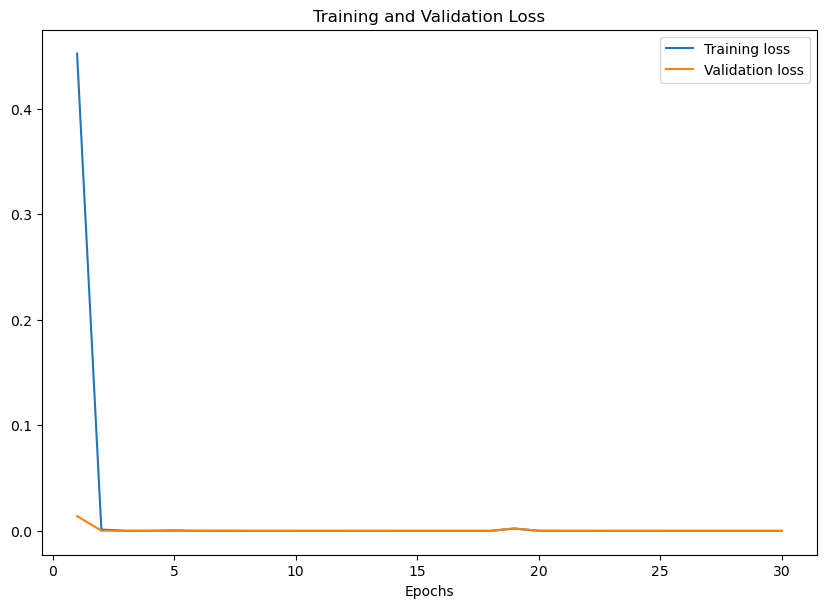

<Figure size 640x480 with 0 Axes>

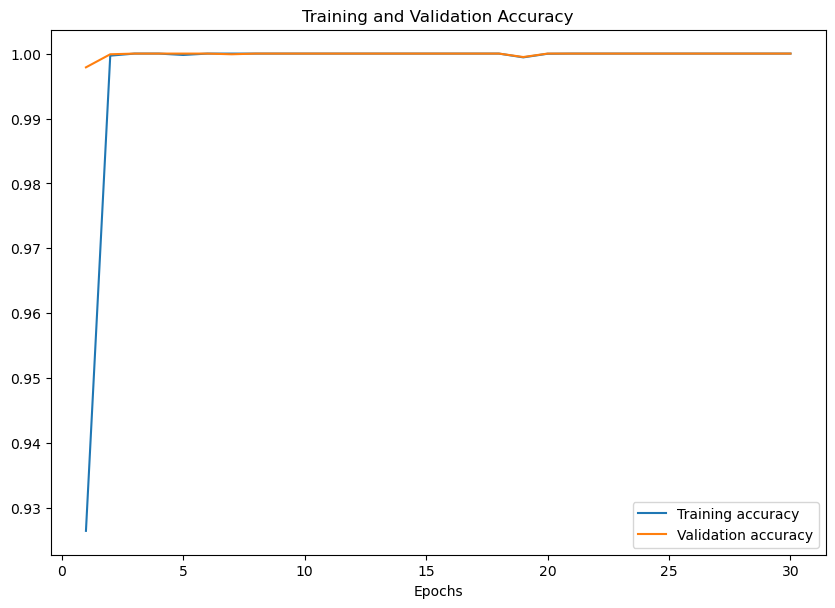

<Figure size 640x480 with 0 Axes>

In [14]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

## Test the network on the test data

We have trained the network over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  Chest CT,    Hand,   Chest CT,   Chest X-Ray,   Chest CT,   Chest CT,   Breast MRI,   Breast MRI,   Abdomen CT,   Abdomen CT,    Hand,   Abdomen CT,   Chest X-Ray,   Breast MRI,   Chest X-Ray,   Chest X-Ray,   Breast MRI,    Hand,   Chest X-Ray,   Chest CT,  


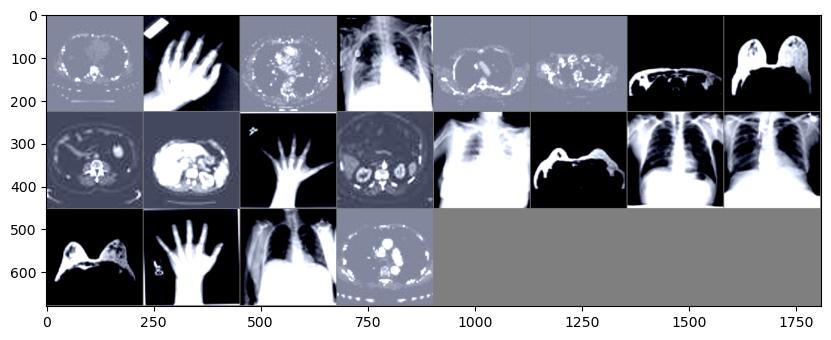

In [15]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s,  ' % classes[labels[j]] for j in range(len(labels))))

Okay, now let us check the performance on the test network:



In [16]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 100 %


In [17]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Abdomen CT : 99 %
Accuracy of Breast MRI : 99 %
Accuracy of Chest X-Ray : 99 %
Accuracy of Chest CT : 99 %
Accuracy of  Hand : 99 %
Accuracy of Head CT : 99 %


### Confusion Matrix

In [18]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
cm = confusion_matrix.numpy()

tensor([[2000.,    0.,    0.,    0.,    0.,    0.],
        [   0., 1791.,    0.,    0.,    0.,    0.],
        [   0.,    0., 2000.,    0.,    0.,    0.],
        [   0.,    0.,    0., 2000.,    0.,    0.],
        [   0.,    0.,    0.,    0., 2000.,    0.],
        [   0.,    0.,    0.,    0.,    0., 2000.]])


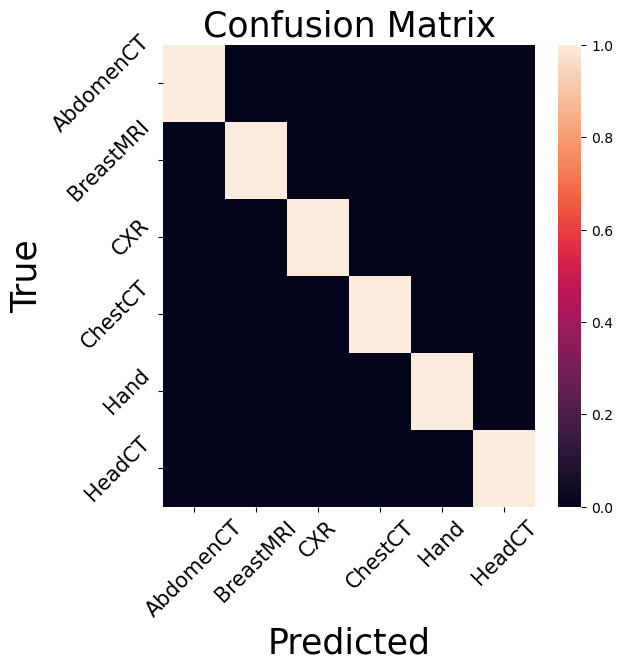

In [19]:
fig,ax= plt.subplots(figsize=(len(classes),len(classes)))
sns.heatmap(cm / (cm.astype(float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['AbdomenCT','BreastMRI','CXR','ChestCT','Hand','HeadCT'], size=15); \
ax.yaxis.set_ticklabels(['AbdomenCT','BreastMRI','CXR','ChestCT','Hand','HeadCT'], size=15); \
plt.xticks(rotation = 45); \
plt.yticks(rotation = 45);



### Grad cam

In [20]:
from collections import OrderedDict, Sequence

class _BaseWrapper(object):
    """
    Please modify forward() and backward() according to your task.
    """

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        """
        Simple classification
        """
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
        """
        Class-specific backpropagation
        Either way works:
        1. self.logits.backward(gradient=one_hot, retain_graph=True)
        2. (self.logits * one_hot).sum().backward(retain_graph=True)
        """

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save featuremaps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

/tmp/ipykernel_13086/3564839669.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Sequence


Generating Grad-CAM @layer4
	#0: Breast MRI (1.00000)


/home/viet/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


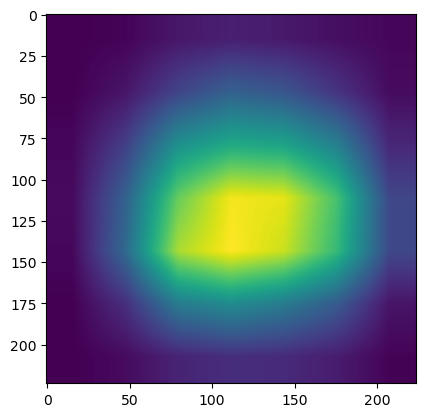

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Class:  Breast MRI


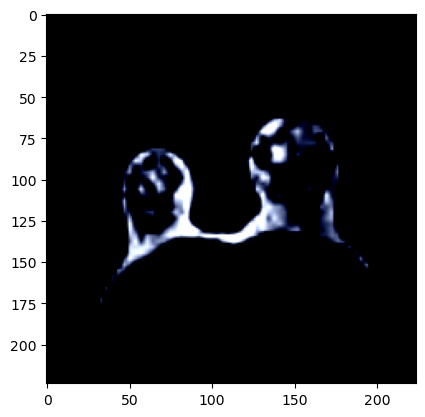

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


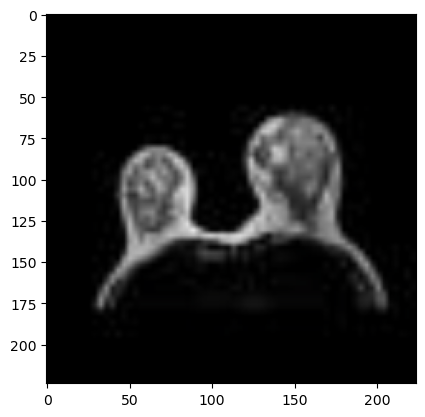

In [21]:
def demo2(image, label, model):
    """
    Generate Grad-CAM
    """
    # Model
    model = model
    model.to(device)
    model.eval()

    # The layers
    target_layers = ["layer4"]
    target_class = label

    # Images
    images = image.unsqueeze(0)
    gcam = GradCAM(model=model)
    probs, ids = gcam.forward(images)
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)
        for j in range(len(images)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )
            
            gcam=regions[j, 0]
            plt.imshow(gcam.cpu())
            plt.show()
            
image, label = next(iter(test_data_loader))
# Load the model
model = original_net
# Grad cam
demo2(image[0].to(device), label[0].to(device), model)


image = np.transpose(image[0], (1,2,0))
image2  = np.add(np.multiply(image.numpy(), np.array(norm_std)) ,np.array(norm_mean))
print("True Class: ", classes[label[0].cpu()])
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()



### Save trained model

In [22]:
torch.save(net.state_dict(), "resnet50-medical-image-classifier")